In [1]:
# ! pip install neuralprophet[live]

In [2]:
import os
import sys
import torch 
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet

In [3]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [4]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 1
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 30
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [5]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # # cal roll mean
    # regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    # regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    # regions_df[region] = (regions_df[region]-regions_df[region].min())/(regions_df[region].max()-regions_df[region].min())
    
    # # add week info
    # regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    # regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [6]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W
date,,,,,,,,,,,,,,,
2013-03-01,7.125000,10.750000,11.708333,22.583333,429.166667,63.875000,1.391667,1026.875000,-18.745833,0.0,3.254167,1.000000,0.000000,0.291667,0.416667
2013-03-02,30.750000,42.083333,36.625000,66.666667,824.916667,29.750000,0.616667,1026.850000,-15.937500,0.0,1.479167,0.625000,0.208333,0.583333,0.375000
2013-03-03,76.916667,120.541667,61.291667,81.000000,1620.625000,19.125000,5.566667,1014.608333,-12.316667,0.0,1.658333,0.833333,0.083333,0.458333,0.375000
2013-03-04,22.708333,44.583333,23.015778,46.542748,595.019788,53.750000,9.962500,1017.650000,-11.683333,0.0,2.404167,0.500000,0.500000,0.208333,0.416667
2013-03-05,148.875000,183.791667,93.875000,132.833333,2357.958333,68.458333,6.291667,1010.900000,-7.525000,0.0,1.129167,0.833333,0.166667,0.708333,0.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,21.541667,32.625000,16.583333,58.875000,575.000000,50.791667,5.166667,1021.012500,-11.141667,0.0,1.595833,0.791667,0.083333,0.333333,0.625000
2017-02-25,11.208333,19.708333,6.750000,43.375000,420.833333,65.875000,7.245833,1018.812500,-10.754167,0.0,1.825000,0.750000,0.166667,0.083333,0.833333
2017-02-26,28.125000,40.708333,10.083333,65.375000,720.833333,48.625000,7.208333,1020.337500,-8.258333,0.0,1.566667,0.541667,0.416667,0.500000,0.416667


In [7]:
models = {}
metrics = {}
forecasts = {}
feature = "PM10"

# build dataset
df = regions_df[Region.AOTIZHONGXIN][[feature]]
df = df.reset_index()
df.columns = ['ds','y']

for checkpoints in range(10):
    for lags in range(10):
        print(f"***************Training (checkpoints,lags): ({checkpoints},{lags})*****************************")
        # build model
        models[(checkpoints,lags)] = NeuralProphet(
            n_changepoints=checkpoints,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            # Add the autogression
            n_lags=lags,
            epochs=10
        )
 
        # build metrics
        metrics[(checkpoints,lags)] = models[(checkpoints,lags)].fit(df, freq="D")


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


***************Training (checkpoints,lags): (0,3)*****************************


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (0,8)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (0,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (1,5)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (1,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (2,3)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (2,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (3,4)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (3,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (4,7)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (4,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (5,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


***************Training (checkpoints,lags): (6,3)*****************************


INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (6,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (7,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


***************Training (checkpoints,lags): (8,3)*****************************


WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (8,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,0)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,1)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,2)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,3)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,4)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,5)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,6)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,7)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,8)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


***************Training (checkpoints,lags): (9,9)*****************************


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (46) is too small than the required number for the learning rate finder (229). The results might not be optimal.


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (NP.data.splitting._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 1.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.932% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 46it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'e2712c6c-d3bb-4660-b469-6254b39c1d21',
              'x': array([datetime.datetime(2013, 3, 1, 0, 0),
                          datetime.datetime(2013, 3, 2, 0, 0),
                          datetime.datetime(2013, 3, 3, 0, 0), ...,
                          datetime.datetime(2017, 2, 25, 0, 0),
                          datetime.datetime(2017, 2, 26, 0, 0),
                          datetime.datetime(2017, 2, 28, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([258.2048532 , 258.07117835, 257.93750351, ..., 202.52423063,
                          202.49911964, 202.44889765]),
              'yaxis': 'y'},
             {'fill': 'none',
              'line': {'color': '

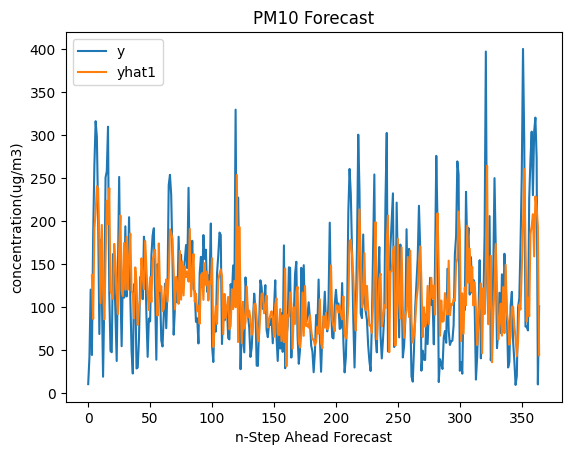

In [8]:
checkpoints = 4
lags = 3

model = NeuralProphet(
            n_changepoints=checkpoints,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            # Add the autogression
            n_lags=lags,
            epochs=10
        )

model.fit(df, freq="D")

future = model.make_future_dataframe(df, n_historic_predictions=True, periods=365)
forecast = model.predict(future)
forecast = forecast.rename({'y':'target','yhat1':'pred'})
forecast[['y','yhat1']][:365].plot(title="PM10 Forecast",xlabel="n-Step Ahead Forecast", ylabel="concentration(ug/m3)")

model.plot_parameters(components=["trend", "seasonality"])